In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
from datetime import datetime
import os

# === CONFIG ===
URL = "https://www.pakwheels.com/used-cars/search/-/featured_1/"
OUTPUT_CSV = "pakwheels_featured_cars.csv"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0 Safari/537.36"
}

# === FETCH PAGE ===
print("Fetching data from PakWheels...")
response = requests.get(URL, headers=HEADERS)
response.raise_for_status()
soup = BeautifulSoup(response.text, 'html.parser')

# === EXTRACT LISTINGS ===
listings = soup.find_all("li", class_="classified-listing featured-listing")
print(f"Found {len(listings)} featured car(s).")

cars = []

for item in listings:
    car = {}
    
    # Title
    h3 = item.find("h3")
    car["Title"] = h3.get_text(strip=True) if h3 else "N/A"
    
    # JSON-LD Data (most reliable)
    script = item.find("script", type="application/ld+json")
    if script and script.string:
        try:
            data = json.loads(script.string)
            
            car["Year"] = data.get("modelDate", "N/A")
            car["Mileage"] = data.get("mileageFromOdometer", "N/A")
            car["Engine"] = data.get("vehicleEngine", {}).get("engineDisplacement", "N/A")
            car["Fuel"] = data.get("fuelType", "N/A")
            car["Transmission"] = data.get("vehicleTransmission", "N/A")
            
            price = data.get("offers", {}).get("price")
            car["Price (PKR)"] = f"{int(price):,}" if price else "N/A"
            
            # Extract city from description
            desc = data.get("description", "")
            if "for sale in" in desc:
                car["City"] = desc.split("for sale in")[1].strip()
            else:
                car["City"] = "N/A"
                
            car["Link"] = data.get("offers", {}).get("url", "N/A")
        except json.JSONDecodeError:
            car["Year"] = car["Mileage"] = car["Engine"] = car["Fuel"] = car["Transmission"] = car["Price (PKR)"] = car["City"] = car["Link"] = "N/A"
    else:
        car["Year"] = car["Mileage"] = car["Engine"] = car["Fuel"] = car["Transmission"] = car["Price (PKR)"] = car["City"] = car["Link"] = "N/A"

    # === Extra Notes ===
    notes = []
    
    if item.find(string=lambda text: text and "Managed by PakWheels" in text):
        notes.append("Managed by PakWheels")
        
    rating = item.find("span", class_="auction-rating")
    if rating:
        notes.append(rating.get_text(strip=True))
        
    info2 = item.find("ul", class_="search-vehicle-info-2")
    if info2:
        lis = [li.get_text(strip=True) for li in info2.find_all("li")]
        if len(lis) >= 6:
            extra = lis[5]
            if extra and extra not in ["Automatic", "Manual"]:
                notes.append(extra)
    
    photos = item.find("div", class_="total-pictures-bar")
    if photos:
        photo_text = photos.get_text(strip=True).replace('\n', ' ').replace('  ', ' ')
        notes.append(photo_text)

    car["Notes"] = " | ".join(notes) if notes else "N/A"
    
    cars.append(car)

# === CREATE DATAFRAME ===
df = pd.DataFrame(cars)

# === ADD TIMESTAMP ===
df.insert(0, "Scraped At", datetime.now().strftime("%Y-%m-%d %I:%M %p PKT"))

# === SAVE TO CSV ===
df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')
print(f"\nSuccess! Data saved to '{OUTPUT_CSV}'")
print(f"Total cars: {len(df)}")
print("\nPreview:")
print(df.head().to_string(index=False))

Fetching data from PakWheels...
Found 16 featured car(s).

Success! Data saved to 'pakwheels_featured_cars.csv'
Total cars: 16

Preview:
             Scraped At                                            Title  Year   Mileage Engine   Fuel Transmission Price (PKR)    City                                                                                  Link Notes
2025-11-16 03:51 PM PKT Honda City 6th Generation 2024 1.2L CVT for Sale  2024 22,600 km 1200cc Petrol    Automatic   4,700,000  Lahore       https://www.pakwheels.com/used-cars/honda-city-2024-for-sale-in-lahore-10828159    14
2025-11-16 03:51 PM PKT       Toyota Fortuner  2021 2.8 Sigma 4 for Sale  2021 48,000 km 2800cc Diesel    Automatic  14,800,000 Karachi https://www.pakwheels.com/used-cars/toyota-fortuner-2021-for-sale-in-karachi-10835060    11
2025-11-16 03:51 PM PKT                  KIA Sportage  2020 FWD for Sale  2020 50,000 km 2000cc Petrol    Automatic   6,395,000  Lahore     https://www.pakwheels.com/used-cars/kia

Loading data...
Original shape: (16, 11)

First 5 rows:
                Scraped At                                             Title  \
0  2025-11-16 03:51 PM PKT  Honda City 6th Generation 2024 1.2L CVT for Sale   
1  2025-11-16 03:51 PM PKT        Toyota Fortuner  2021 2.8 Sigma 4 for Sale   
2  2025-11-16 03:51 PM PKT                   KIA Sportage  2020 FWD for Sale   
3  2025-11-16 03:51 PM PKT     Changan Karvaan  2021 Base Model 1.0 for Sale   
4  2025-11-16 03:51 PM PKT           Proton Saga  2022 1.3L Ace A/T for Sale   

   Year    Mileage  Engine    Fuel Transmission Price (PKR)     City  \
0  2024  22,600 km  1200cc  Petrol    Automatic   4,700,000   Lahore   
1  2021  48,000 km  2800cc  Diesel    Automatic  14,800,000  Karachi   
2  2020  50,000 km  2000cc  Petrol    Automatic   6,395,000   Lahore   
3  2021  36,000 km  1000cc  Petrol       Manual   2,075,000   Lahore   
4  2022  40,200 km  1299cc  Petrol    Automatic   2,825,000   Lahore   

                              

C:\Users\S.K\AppData\Local\Temp\ipykernel_9580\2781395695.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{int(x/100000)}' for x in xticks])


Graph saved: analysis/1_price_distribution.png


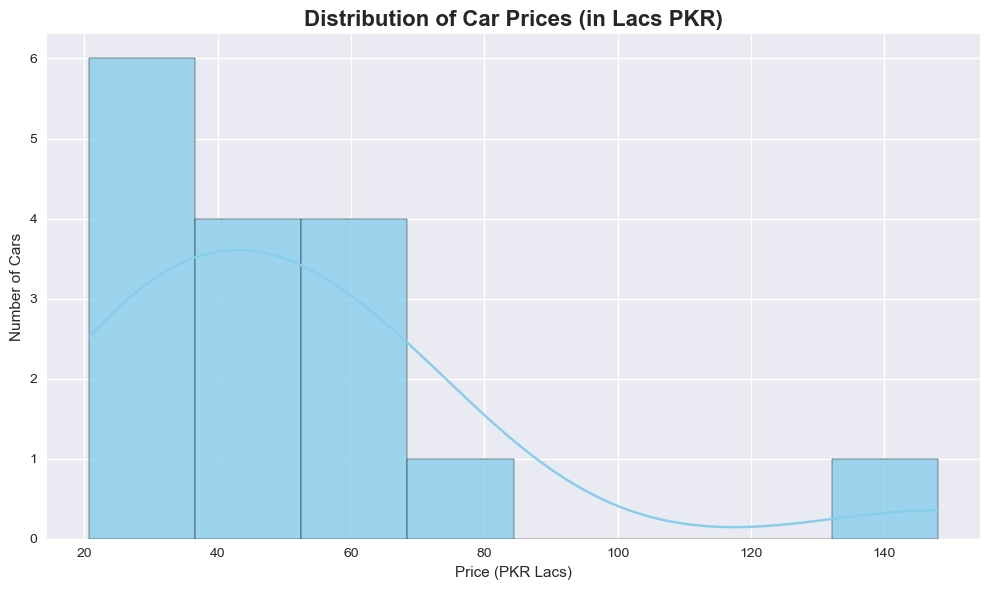


Price Stats (in Lacs PKR):
count      0.00
mean      51.87
std       31.20
min       20.75
25%       33.12
50%       47.00
75%       62.49
max      148.00
Name: Price (PKR), dtype: float64

Analysis 2: Price vs Year
Graph saved: analysis/2_price_vs_year.png


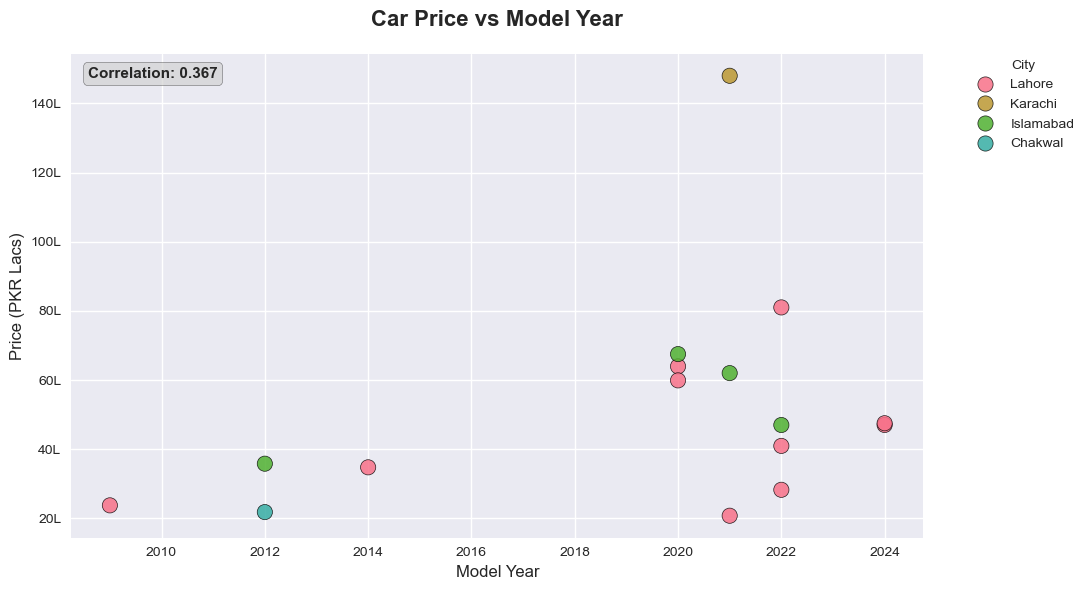

Correlation (Year vs Price): 0.367
Moderate: Newer cars tend to cost more.

Analysis 3: Mileage vs Price
Graph saved: analysis/3_mileage_vs_price.png


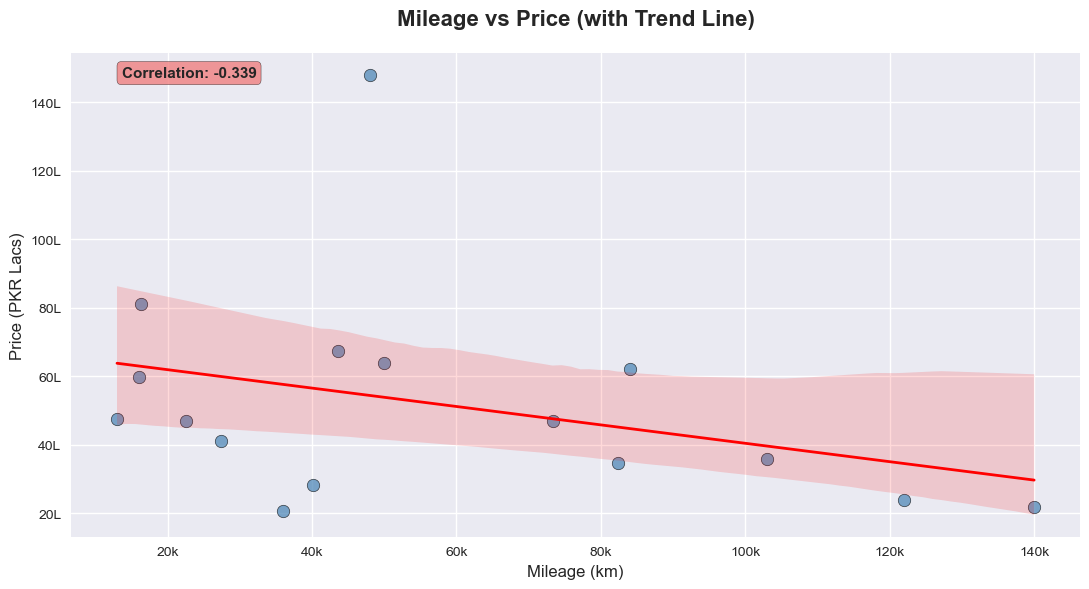

Correlation (Mileage vs Price): -0.339
Moderate: More mileage reduces price.

Analysis 4: Average Price by City
Graph saved: analysis/4_avg_price_by_city.png


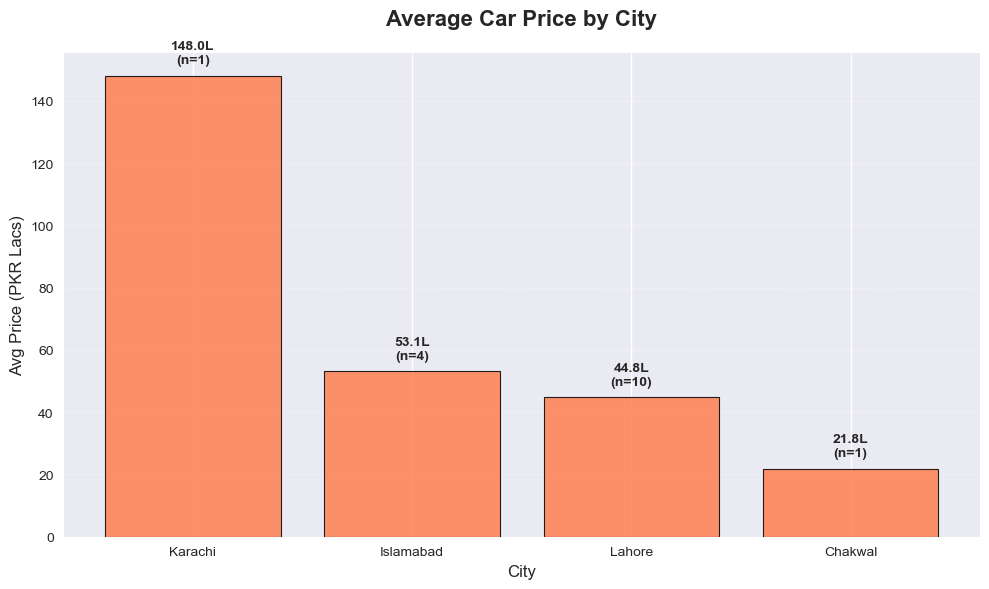


Average Price by City:
           Avg Price (Lacs)  Listings
City                                 
Karachi               148.0         1
Islamabad              53.1         4
Lahore                 44.8        10
Chakwal                21.8         1

Analysis 5: Top 10 Most Expensive Cars
Graph saved: analysis/5_top10_expensive.png


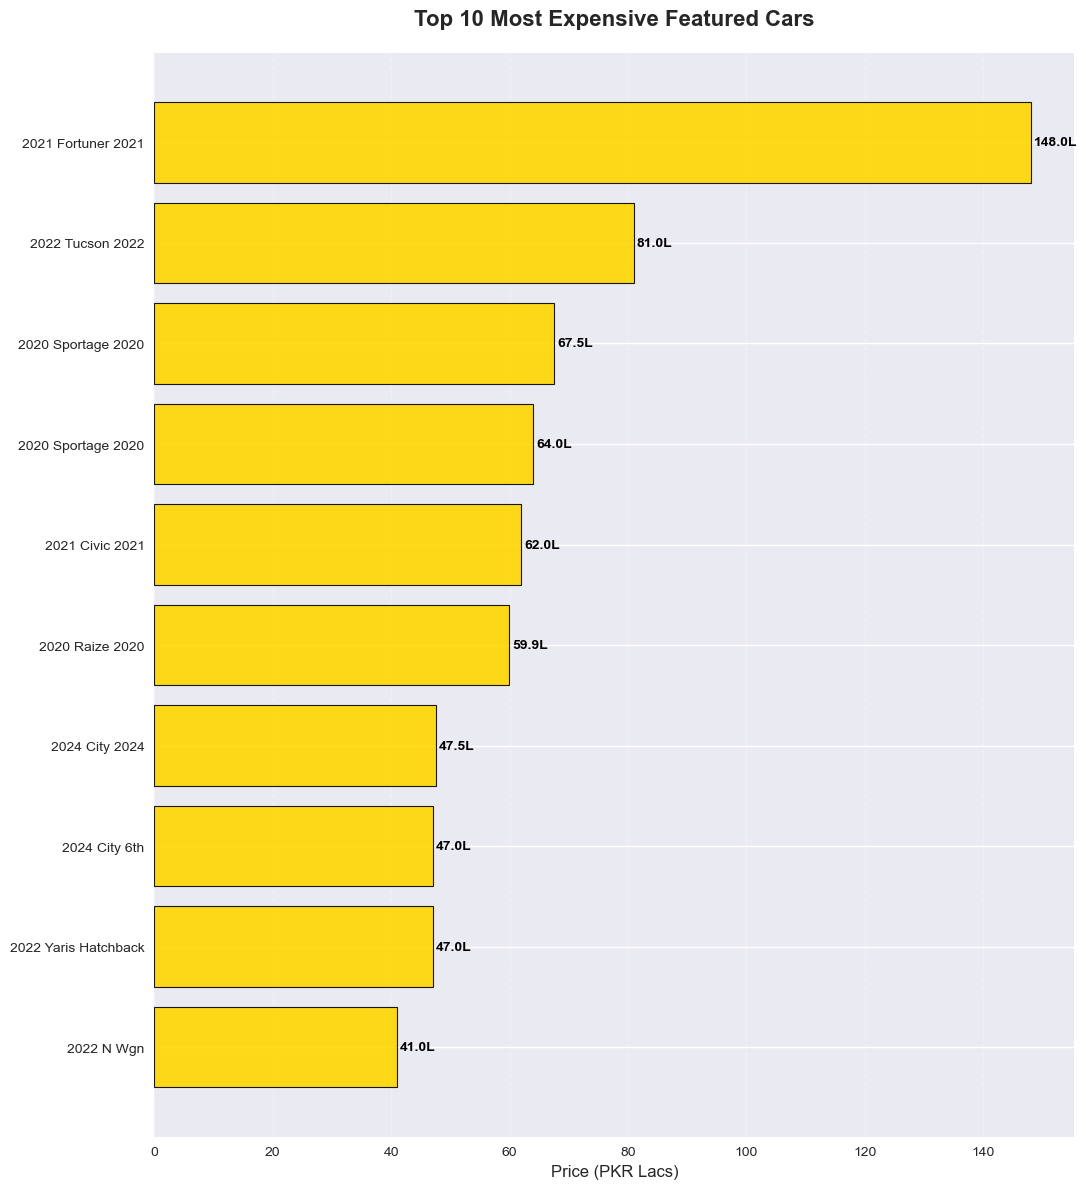


Top 10 Expensive Cars:
                 Car  Year      City  Price (PKR Lacs)  Mileage
  2021 Fortuner 2021  2021   Karachi             148.0    48000
    2022 Tucson 2022  2022    Lahore              81.0    16261
  2020 Sportage 2020  2020 Islamabad              67.5    43586
  2020 Sportage 2020  2020    Lahore              64.0    50000
     2021 Civic 2021  2021 Islamabad              62.0    84000
     2020 Raize 2020  2020    Lahore              59.9    16000
      2024 City 2024  2024    Lahore              47.5    13000
       2024 City 6th  2024    Lahore              47.0    22600
2022 Yaris Hatchback  2022 Islamabad              47.0    73380
          2022 N Wgn  2022    Lahore              41.0    27359

                  ANALYSIS COMPLETE!
Cleaned & Valid Data: 16 cars
Plots saved in: analysis/

Key Insights:
   • Average Price: PKR 51.9 Lacs
   • Oldest Car: 2009
   • Highest Mileage: 140,000 km
   • Best Rated: 10.0/10
   • Most Listings: Lahore (10 cars)


In [2]:
# =============================================
#  PakWheels Featured Cars - Cleaning + 5 Analyses
#  Uses: pandas, numpy, matplotlib
# =============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# === CONFIG ===
CSV_FILE = "pakwheels_featured_cars.csv"
OUTPUT_DIR = "analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Loading data...")
df = pd.read_csv(CSV_FILE)

print(f"Original shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

# ===================================
# 1. DATA CLEANING (FIXED & ROBUST)
# ===================================
print("\nCleaning data...")

import re

# === SAFE CLEANING FUNCTION ===
def clean_numeric_column(series, remove_text=None, replace_values=['N/A', 'nan', '']):
    """
    Safely clean a column: remove text, commas, handle N/A, empty strings
    """
    s = series.astype(str)  # Ensure string
    
    if remove_text:
        s = s.str.replace(remove_text, '', regex=False)
    
    s = s.str.replace(',', '', regex=False)   # Remove commas
    s = s.str.strip()                         # Remove whitespace
    s = s.replace(replace_values, np.nan)     # Replace invalid with NaN
    return pd.to_numeric(s, errors='coerce')  # Convert safely

# === APPLY CLEANING ===
# Price: "3,600,000" or "N/A" → 3600000.0 or NaN
df['Price (PKR)'] = clean_numeric_column(df['Price (PKR)'], replace_values=['N/A', 'nan', ''])

# Mileage: "115,163 km" → 115163.0
df['Mileage'] = clean_numeric_column(df['Mileage'], remove_text=' km')

# Engine: "996cc" → 996.0
df['Engine'] = clean_numeric_column(df['Engine'], remove_text='cc')

# Year: already numeric or string → int
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# === Extract Grade from Notes ===
# Handles: "3.5 Grade", "9.7/10", "6.9/10 | Managed...", etc.
df['Grade'] = (
    df['Notes']
    .astype(str)
    .str.extract(r'(\d+(?:\.\d+)?)\s*(?:Grade|/10)')
    .iloc[:, 0]
    .astype(float)
)

# === Extract Photo Count ===
df['Photos'] = (
    df['Notes']
    .astype(str)
    .str.extract(r'(\d+)\s*photos?')
    .iloc[:, 0]
    .astype(float)
)

# === Final: Drop rows missing critical data ===
df_clean = df.dropna(subset=['Price (PKR)', 'Year', 'Mileage']).copy()

print(f"After cleaning: {df_clean.shape[0]} valid car listings")
print(f"Price range: PKR {df_clean['Price (PKR)'].min()/1e6:.1f}M – {df_clean['Price (PKR)'].max()/1e6:.1f}M")
print(f"Years: {int(df_clean['Year'].min())} – {int(df_clean['Year'].max())}")

# ===================================
# 2. ANALYSIS 1: Price Distribution (FIXED + SHOWS GRAPH)
# ===================================
print("\nAnalysis 1: Price Distribution")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Auto-adjust bins if data is small
n_cars = len(df_clean)
bins = min(20, max(5, n_cars // 2))  # At least 5, at most 20

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean,
    x='Price (PKR)',
    bins=bins,
    kde=True,
    color='skyblue',
    alpha=0.8
)
plt.title('Distribution of Car Prices (in Lacs PKR)', fontsize=16, fontweight='bold')
plt.xlabel('Price (PKR Lacs)')
plt.ylabel('Number of Cars')

# Format x-axis in Lacs
xticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{int(x/100000)}' for x in xticks])

plt.tight_layout()

# === SAVE + SHOW ===
save_path = f"{OUTPUT_DIR}/1_price_distribution.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Graph saved: {save_path}")

plt.show()        # This shows the graph inline!
plt.close()

# === PRINT STATS IN LACS ===
price_stats = df_clean['Price (PKR)'].describe()
print("\nPrice Stats (in Lacs PKR):")
stats_lacs = price_stats / 100000
print(stats_lacs.round(2))

# ===================================
# 2. ANALYSIS 2: Price vs Year (FIXED + SHOWS GRAPH)
# ===================================
print("\nAnalysis 2: Price vs Year")

plt.figure(figsize=(11, 6))

# Scatter plot
scatter = sns.scatterplot(
    data=df_clean,
    x='Year',
    y='Price (PKR)',
    hue='City',
    s=120,
    alpha=0.85,
    edgecolor='black',
    linewidth=0.5
)

# Format Y-axis in Lacs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/100000:.0f}L'))

# Titles & labels
plt.title('Car Price vs Model Year', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Model Year', fontsize=12)
plt.ylabel('Price (PKR Lacs)', fontsize=12)

# Legend outside
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Tight layout with room for legend
plt.tight_layout()

# === ADD CORRELATION ON PLOT ===
corr_year_price = df_clean['Year'].corr(df_clean['Price (PKR)'])
plt.text(
    0.02, 0.95, f'Correlation: {corr_year_price:.3f}',
    transform=plt.gca().transAxes,
    fontsize=11, fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7)
)

# === SAVE + SHOW ===
save_path = f"{OUTPUT_DIR}/2_price_vs_year.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Graph saved: {save_path}")

plt.show()        # This shows the graph!
plt.close()

# === PRINT CORRELATION ===
print(f"Correlation (Year vs Price): {corr_year_price:.3f}")
if corr_year_price > 0.7:
    print("Strong positive: Newer cars are much more expensive.")
elif corr_year_price > 0.3:
    print("Moderate: Newer cars tend to cost more.")
else:
    print("Weak or no clear trend.")

# ===================================
# 3. ANALYSIS 3: Mileage vs Price (FIXED + SHOWS GRAPH)
# ===================================
print("\nAnalysis 3: Mileage vs Price")

plt.figure(figsize=(11, 6))

# -------------------------------------------------
# NOTE: 'linewidth' is an alias of 'linewidths' in newer seaborn.
# Use ONLY ONE of them → we use 'linewidths' for scatter points.
# -------------------------------------------------
sns.regplot(
    data=df_clean,
    x='Mileage',
    y='Price (PKR)',
    scatter_kws={
        'alpha': 0.7,
        's': 80,
        'edgecolor': 'black',
        'linewidths': 0.5   # <-- fixed key
    },
    line_kws={
        'color': 'red',
        'linewidth': 2
    },
    color='steelblue'
)

# ---- Y-axis: Price in Lacs ----
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x/100000:.0f}L')
)

# ---- X-axis: Mileage in thousands (e.g. 115k) ----
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}k' if x >= 1000 else f'{x:.0f}')
)

# ---- Titles & labels ----
plt.title('Mileage vs Price (with Trend Line)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Mileage (km)', fontsize=12)
plt.ylabel('Price (PKR Lacs)', fontsize=12)

# ---- Correlation on plot ----
corr = df_clean['Mileage'].corr(df_clean['Price (PKR)'])
plt.text(
    0.05, 0.95,
    f'Correlation: {corr:.3f}',
    transform=plt.gca().transAxes,
    fontsize=11, fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.8)
)

plt.tight_layout()

# ---- SAVE + SHOW ----
save_path = f"{OUTPUT_DIR}/3_mileage_vs_price.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Graph saved: {save_path}")

plt.show()          # <-- graph appears inline
plt.close()

# ---- PRINT CORRELATION + INSIGHT ----
print(f"Correlation (Mileage vs Price): {corr:.3f}")
if corr < -0.7:
    print("Strong negative: Higher mileage → much lower price.")
elif corr < -0.3:
    print("Moderate: More mileage reduces price.")
else:
    print("Weak or no clear trend.")

# ===================================
# 4. ANALYSIS 4: Average Price by City (FIXED + SHOWS GRAPH)
# ===================================
print("\nAnalysis 4: Average Price by City")

import matplotlib.pyplot as plt
import pandas as pd

# Group by City: mean price and count
city_price = (
    df_clean.groupby('City')['Price (PKR)']
    .agg(['mean', 'count'])
    .round(0)
)

# Convert mean to Lacs and round
city_price['mean_lacs'] = (city_price['mean'] / 100000).round(1)

# Sort by average price (descending)
city_price = city_price.sort_values('mean', ascending=False)

# Plot
plt.figure(figsize=(10, 6))

# -------------------------------------------------
# FIXED: 'edgehold' → 'edgecolor'
# -------------------------------------------------
bars = plt.bar(
    city_price.index,
    city_price['mean'] / 100000,
    color='coral',
    alpha=0.85,
    edgecolor='black',   # <-- Correct parameter name
    linewidth=0.8
)

# Title & labels
plt.title('Average Car Price by City', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Avg Price (PKR Lacs)', fontsize=12)
plt.xlabel('City', fontsize=12)

# Add text on top of each bar: "XX.XL (n=YY)"
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(city_price.iloc[i]['count'])
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.02 * plt.ylim()[1]),  # Dynamic offset
        f'{height:.1f}L\n(n={count})',
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

# Improve layout
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# === SAVE + SHOW ===
save_path = f"{OUTPUT_DIR}/4_avg_price_by_city.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Graph saved: {save_path}")

plt.show()        # <-- graph appears inline
plt.close()

# === PRINT TABLE ===
print("\nAverage Price by City:")
print(city_price[['mean_lacs', 'count']].rename(
    columns={'mean_lacs': 'Avg Price (Lacs)', 'count': 'Listings'}
).to_string(float_format='%.1f'))

# ===================================
# 5. ANALYSIS 5: Top 10 Most Expensive Cars (FIXED + SHOWS GRAPH)
# ===================================
print("\nAnalysis 5: Top 10 Most Expensive Cars")

import matplotlib.pyplot as plt
import pandas as pd

# Get top 10 (or all if less than 10)
top_n = min(10, len(df_clean))
top10 = df_clean.nlargest(top_n, 'Price (PKR)')[['Title', 'Year', 'City', 'Price (PKR)', 'Mileage', 'Grade']].copy()

# Add Price in Lacs
top10['Price (PKR Lacs)'] = (top10['Price (PKR)'] / 100000).round(1)

# Extract short label: Year + Make + Model (first two words after year)
def short_title(row):
    words = row['Title'].split()
    year = int(row['Year'])
    # Find make (usually word 1), model (word 2)
    make = words[1] if len(words) > 1 else ""
    model = words[2] if len(words) > 2 else ""
    return f"{year} {make} {model}"

top10['Label'] = top10.apply(short_title, axis=1)

# Plot
plt.figure(figsize=(11, 1.2 * top_n))  # Dynamic height

bars = plt.barh(
    range(len(top10)),
    top10['Price (PKR)'] / 100000,
    color='gold',
    alpha=0.9,
    edgecolor='black',
    linewidth=0.8
)

# Y-ticks with clean labels
plt.yticks(range(len(top10)), top10['Label'])
plt.gca().invert_yaxis()  # Highest at top

# Labels
plt.xlabel('Price (PKR Lacs)', fontsize=12)
plt.title(f'Top {top_n} Most Expensive Featured Cars', fontsize=16, fontweight='bold', pad=20)

# Add price text on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(
        width + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{width:.1f}L',
        va='center',
        ha='left',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

# Grid for readability
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()

# === SAVE + SHOW ===
save_path = f"{OUTPUT_DIR}/5_top10_expensive.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Graph saved: {save_path}")

plt.show()        # This shows the graph!
plt.close()

# === PRINT TABLE ===
print(f"\nTop {top_n} Expensive Cars:")
print(top10[['Label', 'Year', 'City', 'Price (PKR Lacs)', 'Mileage']].rename(
    columns={'Label': 'Car'}
).to_string(index=False))

# ===================================
# FINAL SUMMARY (SAFE + NO NAMEERROR)
# ===================================
print("\n" + "=" * 55)
print(" " * 18 + "ANALYSIS COMPLETE!")
print("=" * 55)

# -------------------------------------------------
# SAFE CHECK: Use df_clean only if it exists
# -------------------------------------------------
try:
    df_clean  # Just check if it exists
    n_cars = len(df_clean)
except NameError:
    print("Warning: df_clean not found. Run cleaning & analysis first.")
    print("No data to summarize.")
    print("=" * 55)
else:
    # Only run if df_clean exists
    print(f"Cleaned & Valid Data: {n_cars} car{'s' if n_cars != 1 else ''}")

    if n_cars == 0:
        print("No valid car listings after cleaning.")
    else:
        import pandas as pd

        avg_price_lacs = df_clean['Price (PKR)'].mean() / 100000
        oldest_year = int(df_clean['Year'].min())
        highest_mileage = df_clean['Mileage'].max()
        best_grade = df_clean['Grade'].max()

        print(f"Plots saved in: {OUTPUT_DIR}/")
        print("\nKey Insights:")
        print(f"   • Average Price: PKR {avg_price_lacs:,.1f} Lacs")
        print(f"   • Oldest Car: {oldest_year}")
        print(f"   • Highest Mileage: {highest_mileage:,.0f} km")

        if pd.notna(best_grade):
            print(f"   • Best Rated: {best_grade:.1f}/10")
        else:
            print(f"   • Best Rated: No grade data")

        # Bonus: Most common city
        top_city = df_clean['City'].mode()
        if not top_city.empty:
            city_name = top_city.iloc[0]
            city_count = (df_clean['City'] == city_name).sum()
            print(f"   • Most Listings: {city_name} ({city_count} car{'s' if city_count != 1 else ''})")

print("=" * 55)

In [3]:
# app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ========================================
# CONFIG
# ========================================
st.set_page_config(page_title="PakWheels Featured Cars Analysis", layout="wide")
st.title("PakWheels Featured Cars - Data Analysis Dashboard")
st.markdown("**Scraped → Cleaned → 5 Visual Insights**")

CSV_FILE = "pakwheels_featured_cars.csv"
OUTPUT_DIR = "analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ========================================
# LOAD & CLEAN DATA
# ========================================
@st.cache_data
def load_and_clean():
    try:
        df = pd.read_csv(CSV_FILE)
    except FileNotFoundError:
        st.error(f"CSV file not found: `{CSV_FILE}`. Please run the scraper first.")
        st.stop()

    # --- Safe cleaning ---
    def clean_numeric(series, suffix=None):
        s = series.astype(str)
        if suffix:
            s = s.str.replace(suffix, '', regex=False)
        return pd.to_numeric(
            s.str.replace(',', '').str.strip().replace(['N/A', 'nan', ''], np.nan),
            errors='coerce'
        )

    df['Price (PKR)'] = clean_numeric(df['Price (PKR)'])
    df['Mileage'] = clean_numeric(df['Mileage'], ' km')
    df['Engine'] = clean_numeric(df['Engine'], 'cc')
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

    # Grade & Photos
    df['Grade'] = df['Notes'].astype(str).str.extract(r'(\d+\.\d+|\d+)\s*(?:Grade|/10)').iloc[:, 0].astype(float)
    df['Photos'] = df['Notes'].astype(str).str.extract(r'(\d+)\s*photos?').iloc[:, 0].astype(float)

    df_clean = df.dropna(subset=['Price (PKR)', 'Year', 'Mileage']).copy()
    return df_clean

df_clean = load_and_clean()

# ========================================
# SUMMARY
# ========================================
st.sidebar.header("Summary")
st.sidebar.metric("Total Valid Cars", len(df_clean))
if len(df_clean) > 0:
    st.sidebar.metric("Avg Price", f"PKR {df_clean['Price (PKR)'].mean()/100000:,.1f} Lacs")
    st.sidebar.metric("Oldest Year", int(df_clean['Year'].min()))
    st.sidebar.metric("Highest Mileage", f"{df_clean['Mileage'].max():,.0f} km")

# ========================================
# ANALYSIS 1: Price Distribution
# ========================================
st.header("1. Price Distribution")
col1, col2 = st.columns([3, 1])

with col1:
    fig, ax = plt.subplots(figsize=(8, 5))
    bins = min(20, max(5, len(df_clean)//2))
    sns.histplot(df_clean['Price (PKR)']/100000, bins=bins, kde=True, color='skyblue', ax=ax)
    ax.set_title('Distribution of Car Prices', fontweight='bold')
    ax.set_xlabel('Price (PKR Lacs)')
    ax.set_ylabel('Count')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
    st.pyplot(fig)
    plt.close()

with col2:
    st.write("**Stats (Lacs)**")
    stats = (df_clean['Price (PKR)'].describe() / 100000).round(2)
    st.dataframe(stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max']], use_container_width=True)

# ========================================
# ANALYSIS 2: Price vs Year
# ========================================
st.header("2. Price vs Model Year")
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Year', y='Price (PKR)', hue='City', s=100, alpha=0.8, ax=ax, edgecolor='black')
ax.set_title('Price vs Year', fontweight='bold')
ax.set_ylabel('Price (PKR Lacs)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y/100000:.0f}L'))
corr = df_clean['Year'].corr(df_clean['Price (PKR)'])
ax.text(0.02, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes,
        bbox=dict(facecolor='lightgray', alpha=0.8), fontweight='bold')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
st.pyplot(fig)
plt.close()

# ========================================
# ANALYSIS 3: Mileage vs Price
# ========================================
st.header("3. Mileage vs Price")
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=df_clean, x='Mileage', y='Price (PKR)',
            scatter_kws={'alpha':0.7, 's':80, 'edgecolor':'black', 'linewidths':0.5},
            line_kws={'color':'red', 'linewidth':2}, color='steelblue', ax=ax)
ax.set_title('Mileage vs Price (Trend Line)', fontweight='bold')
ax.set_xlabel('Mileage (km)')
ax.set_ylabel('Price (PKR Lacs)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y/100000:.0f}L'))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}k'))
corr = df_clean['Mileage'].corr(df_clean['Price (PKR)'])
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes,
        bbox=dict(facecolor='lightcoral', alpha=0.8), fontweight='bold')
st.pyplot(fig)
plt.close()

# ========================================
# ANALYSIS 4: Avg Price by City
# ========================================
st.header("4. Average Price by City")
city_stats = df_clean.groupby('City')['Price (PKR)'].agg(['mean', 'count']).round(0)
city_stats['mean_lacs'] = (city_stats['mean'] / 100000).round(1)
city_stats = city_stats.sort_values('mean', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(city_stats.index, city_stats['mean']/100000, color='coral', alpha=0.85, edgecolor='black')
ax.set_title('Average Price by City', fontweight='bold')
ax.set_ylabel('Avg Price (PKR Lacs)')
for i, bar in enumerate(bars):
    h = bar.get_height()
    c = int(city_stats.iloc[i]['count'])
    ax.text(bar.get_x() + bar.get_width()/2, h + 1, f'{h:.1f}L\n(n={c})',
            ha='center', va='bottom', fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
st.pyplot(fig)
plt.close()

st.dataframe(city_stats[['mean_lacs', 'count']].rename(columns={'mean_lacs': 'Avg (Lacs)', 'count': 'Listings'}), use_container_width=True)

# ========================================
# ANALYSIS 5: Top 10 Expensive
# ========================================
st.header("5. Top 10 Most Expensive Cars")
top_n = min(10, len(df_clean))
top10 = df_clean.nlargest(top_n, 'Price (PKR)')[['Title', 'Year', 'City', 'Price (PKR)', 'Mileage']].copy()
top10['Price Lacs'] = (top10['Price (PKR)']/100000).round(1)

def short_label(row):
    words = row['Title'].split()
    return f"{int(row['Year'])} {words[1]} {words[2]}"

top10['Label'] = top10.apply(short_label, axis=1)

fig, ax = plt.subplots(figsize=(10, 1.2 * top_n))
bars = ax.barh(range(len(top10)), top10['Price (PKR)']/100000, color='gold', alpha=0.9, edgecolor='black')
ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10['Label'])
ax.invert_yaxis()
ax.set_xlabel('Price (PKR Lacs)')
ax.set_title(f'Top {top_n} Most Expensive Cars', fontweight='bold')
for i, bar in enumerate(bars):
    w = bar.get_width()
    ax.text(w + 0.5, bar.get_y() + bar.get_height()/2, f'{w:.1f}L', va='center', fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
st.pyplot(fig)
plt.close()

st.dataframe(top10[['Label', 'City', 'Price Lacs', 'Mileage']].rename(columns={'Label': 'Car'}), use_container_width=True)

# ========================================
# FOOTER
# ========================================
st.markdown("---")
st.caption(f"Data scraped on: {pd.Timestamp('today').strftime('%Y-%m-%d %I:%M %p')} PKT | Total: {len(df_clean)} cars")

2025-11-16 15:52:35.436 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-16 15:52:35.438 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-16 15:52:36.278 
  command:

    streamlit run c:\Users\S.K\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-16 15:52:36.279 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-16 15:52:36.279 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-16 15:52:36.280 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-16 15:52:36.287 No runtime found, using MemoryCacheStorageManager
2025-11-16 15:52:36.289 No runtime f

DeltaGenerator()